In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
import math

# import json
# with open('510050_20230214.json') as user_file:
#   parsed_json = json.load(user_file)
# tickers = []
# for i in parsed_json["StockComponent"].keys():
#   tickers.append(i+".SH")

import tushare as ts
ts.set_token('0742c95bee169abeccdf80bbdce1b2e0cf2ac4d83cbd932b608300fd')
pro = ts.pro_api()
tickers = pro.index_weight(index_code='000016.SH', trade_date=20210630, 
                        fields=["con_code"])["con_code"].to_list()
                        
def get_returns(tickers, start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns

In [2]:
start = '20200610'
end = '20230306'
original_returns = get_returns(tickers, start, end)
# returns = original_returns.iloc[0:100] # using a 60-day trailing window, which corresponds roughly to an earnings cycle.
# returns = (returns - returns.mean())/returns.std()

In [3]:
window_lengths = np.array([60,100,150,200,250,300,340,380])
examine = pd.DataFrame(index=original_returns.index,columns=window_lengths)
for window_length in window_lengths:
    max_p_value = 0
    for cur_num in range(window_length, original_returns.shape[0]):
        returns = original_returns.iloc[cur_num-window_length:cur_num]
        # Bartlett's球状检验
        # 若P值远小于0.05,拒绝原假设,说明变量之间有相关关系,可以做主成分分析
        from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
        
        chi_square_value, p_value = calculate_bartlett_sphericity(returns)
        if p_value > max_p_value:max_p_value = p_value
        
        # KMO检验
        # 检查变量间的相关性和偏相关性，取值在0-1之间；KOM统计量越接近1，变量间的相关性越强，偏相关性越弱，主成分分析的效果越好。
        from factor_analyzer.factor_analyzer import calculate_kmo
        
        kmo_all, kmo_model = calculate_kmo(returns)
        examine.loc[original_returns.index[cur_num-1]][window_length] = kmo_model
    print('window_length={} max_p_value={}'.format(window_length,max_p_value))
print(examine.astype('float64').describe())


d:\anaconda\lib\site-packages\factor_analyzer\utils.py:245: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  "The inverse of the variance-covariance matrix "


window_length=60 max_p_value=1.5799723222806901e-83
window_length=100 max_p_value=1.3873145680196791e-208
window_length=150 max_p_value=0
window_length=200 max_p_value=0
window_length=250 max_p_value=0
window_length=300 max_p_value=0
window_length=340 max_p_value=0
window_length=380 max_p_value=0


,60,100,150,200,250,300,340,380
count,491,451,401,351,301,251,211,171
mean,0.591185,0.822222,0.880493,0.904242,0.917435,0.925941,0.930449,0.932996
std,0.0848,0.050032,0.0378,0.029273,0.022427,0.014844,0.009728,0.006838
min,0.378403,0.72727,0.822302,0.854879,0.877372,0.891158,0.912046,0.919901
max,0.794592,0.889793,0.924633,0.939229,0.943409,0.944924,0.943926,0.944789


In [5]:
examine.astype('float64').describe()

,60,100,150,200,250,300,340,380
count,491.000000,451.000000,401.000000,351.000000,301.000000,251.000000,211.000000,171.000000
mean,0.591185,0.822222,0.880493,0.904242,0.917435,0.925941,0.930449,0.932996
std,0.084800,0.050032,0.037800,0.029273,0.022427,0.014844,0.009728,0.006838
min,0.378403,0.727270,0.822302,0.854879,0.877372,0.891158,0.912046,0.919901
25%,0.525430,0.773050,0.837450,0.870568,0.906005,0.913743,0.918860,0.926546
50%,0.578495,0.840552,0.902739,0.917361,0.922555,0.926969,0.932543,0.934675
75%,0.658509,0.871720,0.914693,0.930392,0.938086,0.939677,0.941225,0.938340
max,0.794592,0.889793,0.924633,0.939229,0.943409,0.944924,0.943926,0.944789


In [24]:
# KMO测度
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr, ncol_inv_corr))
    for i in range(0, nrow_inv_corr, 1):
        for j in range(i, ncol_inv_corr, 1):
            A[i, j] = -(corr_inv[i, j]) / (math.sqrt(corr_inv[i, i] * corr_inv[j, j]))
            A[j, i] = A[i, j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

print("\nKMO测度:", kmo(returns.corr()))



KMO测度: 0.943134944004392


In [7]:
vars = np.array([0.5,0.55,0.6,0.65,0.7])
means = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
stds = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
cum_ret = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])

for var in vars:    
    cur_ret_P = []
    cur_ret_P__ = []
    cur_ret_P_ = []
    cum_ret_P = [0]
    cum_ret_P_ = [0]
    cum_ret_P__ = [0]
    date = []
    window_length = 60 # time window
    t1 = timer()
    # num_long_short = pd.DataFrame(columns=['long','short'],index=original_returns.index)
    # z_df = pd.DataFrame(columns=original_returns.index,index=original_returns.columns)
    for cur_num in range(window_length, original_returns.shape[0]):
        date.append(original_returns.index[cur_num-1])
        # print('date:', date[-1])
        # 获取标准化实验数据
        returns = original_returns.iloc[cur_num-window_length:cur_num]
        returns = (returns - returns.mean())/returns.std()
        eigenvals, eigenvecs = np.linalg.eig(returns.corr())
        idx = eigenvals.argsort()[::-1]   
        pca_eigenvals = eigenvals[idx]/sum(eigenvals)
        for i in range(0, len(pca_eigenvals)+1):
            if sum(pca_eigenvals[:i]) >= var:
                # pca_eigenvecs = np.sqrt(eigenvals[idx][:i]) * eigenvecs[:, idx][:, :i]
                pca_eigenvecs = eigenvecs[:, idx][:, :i]
                break
        factors_P = sm.add_constant(np.dot(returns, pca_eigenvecs))
        OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
        resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
        zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
        long_P = zscores_P[zscores_P < -1.5]
        short_P = zscores_P[zscores_P > 2.5]
        # PCA选股
        if len(long_P) != 0:
            weights_long_P = long_P * (1 / long_P.sum())
            # print('long:', end=' ')
            # for stock, weight in weights_long_P.items():
            #     print(stock+': %.4f'%weight, end='  ')
        else: weights_long_P = long_P
        if len(short_P) != 0:
            weights_short_P = short_P * (1 / short_P.sum())
            # print('short:', end=' ')
            # for stock, weight in weights_short_P.items():
            #     print(stock+': %.4f'%weight, end='  ')
        else: weights_short_P = short_P
        cur_ret_P.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2 - original_returns.iloc[cur_num].mean())
        cur_ret_P_.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2)
        cur_ret_P__.append(original_returns.iloc[cur_num].mean())
        cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
        cum_ret_P_.append((1+cum_ret_P_[-1])*(1+cur_ret_P_[-1])-1)
        cum_ret_P__.append((1+cum_ret_P__[-1])*(1+cur_ret_P__[-1])-1)
        # print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
        # print('cum ret：%.4f'%cum_ret_P[-1])
        # num_long_short.loc[date[-1]] = [len(long_P),len(short_P)]
        # z_df[date[-1]] = zscores_P

    # num_long_short = num_long_short.dropna()
    # z_df = z_df.dropna(axis=1)
    df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_P_[:],cur_ret_P__[:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cur.plot()
    plt.title('cur ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()
    dcb = df_cur.describe()
    means.loc[var] = dcb.loc['mean']
    stds.loc[var] = dcb.loc['std']
    cum_ret.at[var,'alpha'] = cum_ret_P[-1]
    cum_ret.at[var,'alpha+beta'] = cum_ret_P_[-1]
    cum_ret.at[var,'beta'] = cum_ret_P__[-1]
    df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_P_[1:],cum_ret_P__[1:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cum.plot()
    plt.title('cum ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()
    t2 = timer()
    print('用时：', t2-t1)
means.plot()
plt.title('means')
plt.xticks(rotation=30, fontsize=8)
plt.show()
stds.plot()
plt.title('stds')
plt.xticks(rotation=30, fontsize=8)
plt.show()
cum_ret.plot()
plt.title('cum_ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

KeyboardInterrupt: 

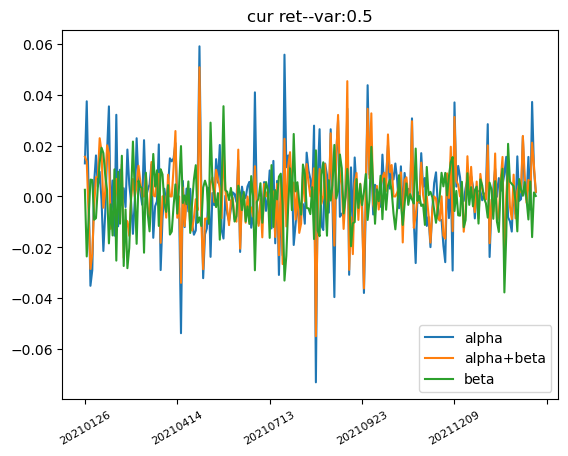

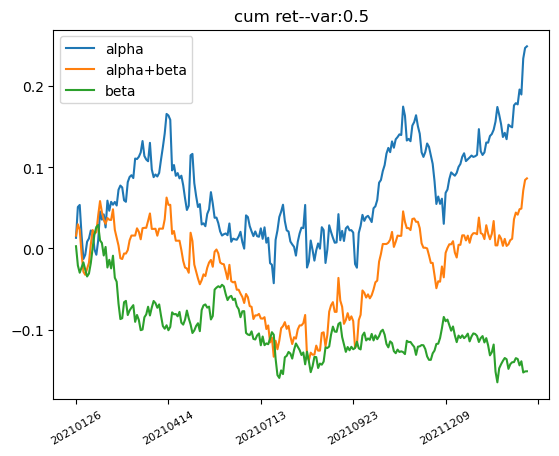

用时： 9.2499669000008


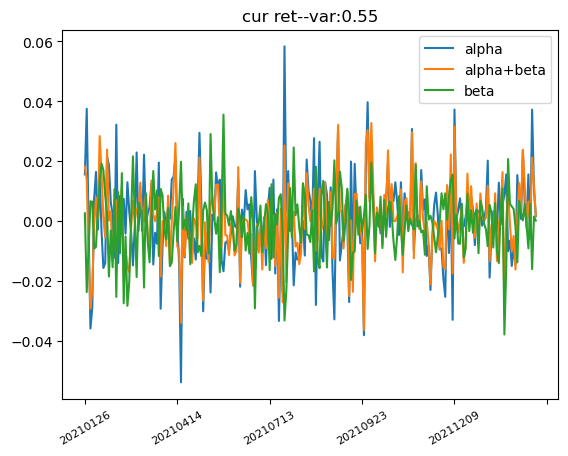

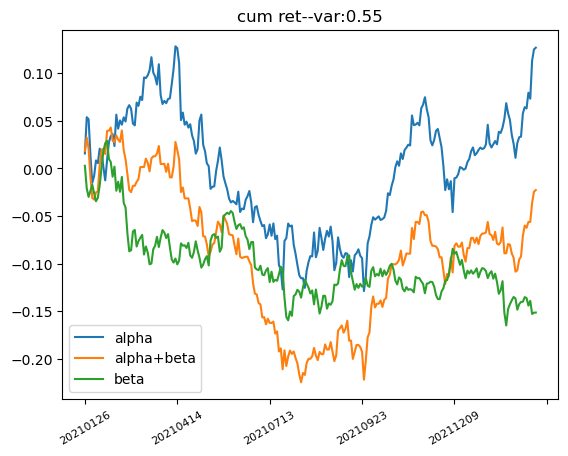

用时： 11.129637599999114


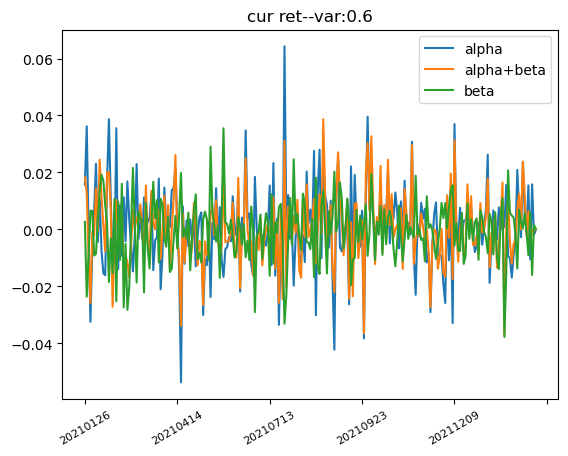

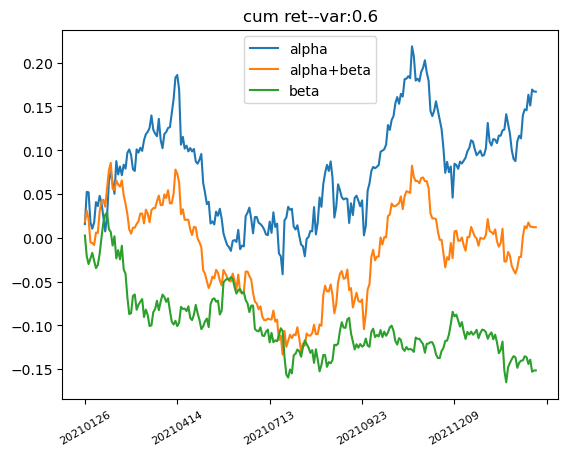

用时： 10.701774600000135


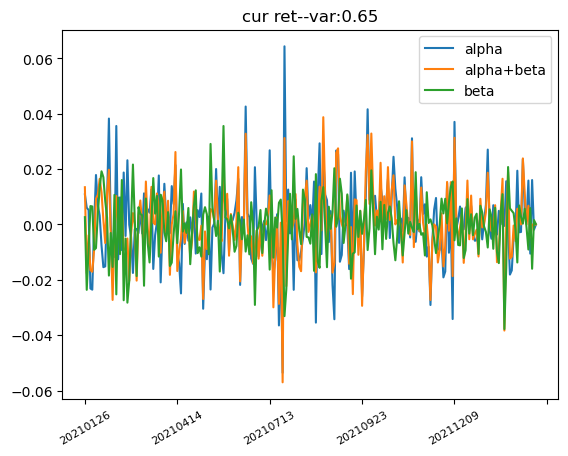

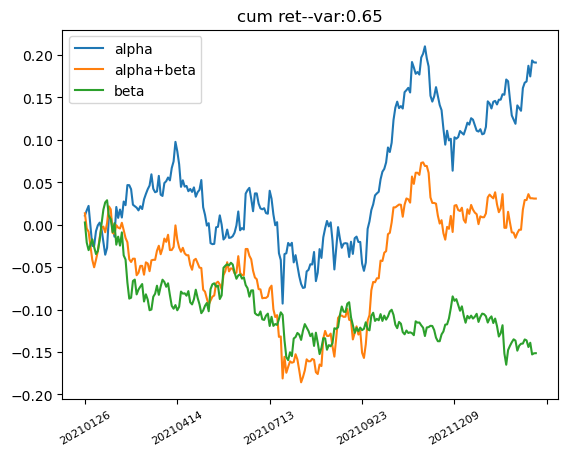

用时： 10.664021700000376


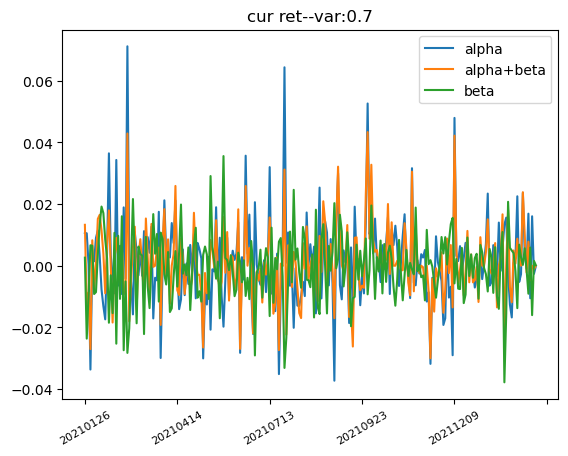

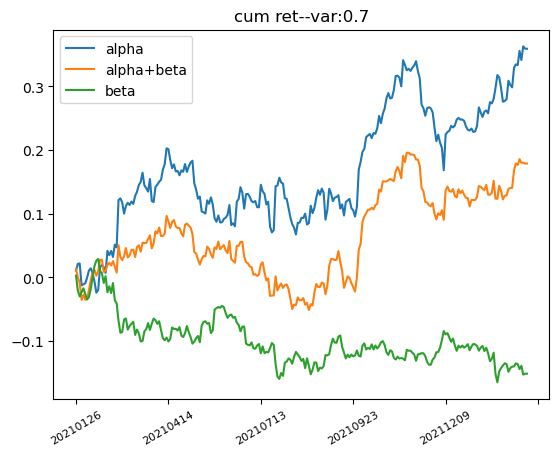

用时： 11.110083300000042


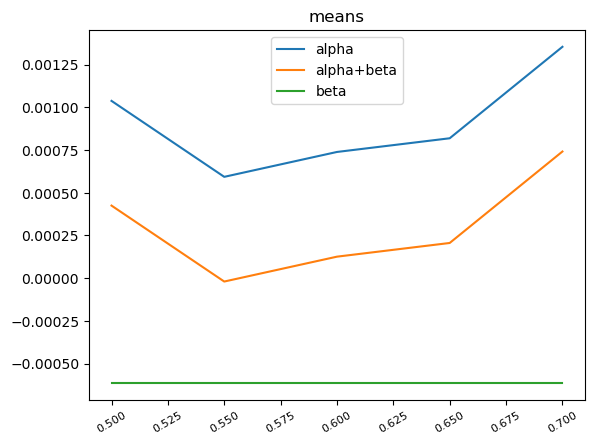

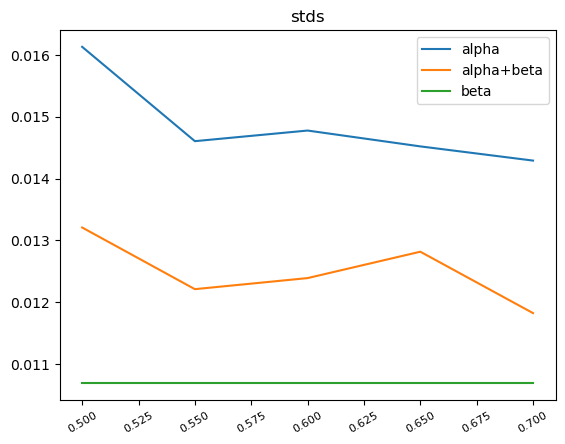

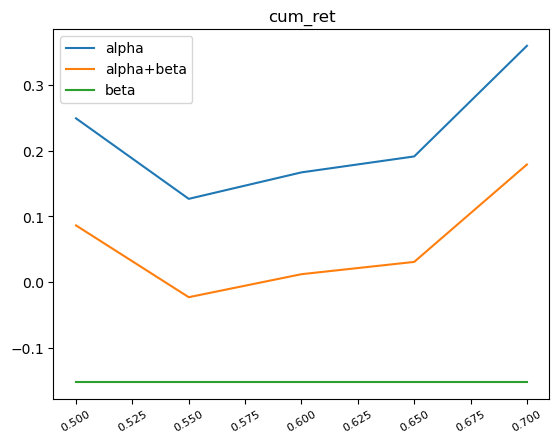

In [30]:
start = '20201101'
end = '20220228'
original_returns = get_returns(tickers, start, end)
vars = np.array([0.5,0.55,0.6,0.65,0.7]) #方差解释率阈值
means = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
stds = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
cum_ret = pd.DataFrame(index=vars,columns=['alpha','alpha+beta','beta'])
for var in vars:    
    cur_ret_P = []
    cur_ret_P__ = []
    cur_ret_P_ = []
    cum_ret_P = [0]
    cum_ret_P_ = [0]
    cum_ret_P__ = [0]
    date = []
    window_length = 60 # time window
    t1 = timer()
    for cur_num in range(window_length, original_returns.shape[0]):
        returns = original_returns.iloc[cur_num-window_length:cur_num]
        returns = (returns - returns.mean())/returns.std()
        eigenvals, eigenvecs = np.linalg.eig(returns.corr())
        idx = eigenvals.argsort()[::-1]   
        pca_eigenvals = eigenvals[idx]/sum(eigenvals)

        ### 取累计方差解释率大于阈值的主成分个数
        for i in range(0, len(pca_eigenvals)+1):
            if sum(pca_eigenvals[:i]) >= var:
                pca_eigenvecs = eigenvecs[:, idx][:, :i]
                break
        
        factors_P = sm.add_constant(np.dot(returns, pca_eigenvecs))
        OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
        resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
        zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
        long_P = zscores_P[zscores_P < -1.5]
        short_P = zscores_P[zscores_P > 2.5]
        if len(long_P) != 0:
            weights_long_P = long_P * (1 / long_P.sum())
        else: weights_long_P = long_P
        if len(short_P) != 0:
            weights_short_P = short_P * (1 / short_P.sum())
        else: weights_short_P = short_P

        ### 计算当天收益率和累计收益率['alpha','alpha+beta','beta']
        cur_ret_P.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2 - original_returns.iloc[cur_num].mean())
        cur_ret_P_.append((sum(weights_long_P*original_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*original_returns[weights_short_P.index].iloc[cur_num]))/2)
        cur_ret_P__.append(original_returns.iloc[cur_num].mean())
        cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
        cum_ret_P_.append((1+cum_ret_P_[-1])*(1+cur_ret_P_[-1])-1)
        cum_ret_P__.append((1+cum_ret_P__[-1])*(1+cur_ret_P__[-1])-1)

    df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_P_[:],cur_ret_P__[:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cur.plot()
    plt.title('cur ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()

    ### 日收益率的均值、方差；累计收益率
    dcb = df_cur.describe()
    means.loc[var] = dcb.loc['mean']
    stds.loc[var] = dcb.loc['std']
    cum_ret.at[var,'alpha'] = cum_ret_P[-1]
    cum_ret.at[var,'alpha+beta'] = cum_ret_P_[-1]
    cum_ret.at[var,'beta'] = cum_ret_P__[-1]

    df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_P_[1:],cum_ret_P__[1:]]).T, columns=['alpha','alpha+beta','beta'], index=np.array(date))
    df_cum.plot()
    plt.title('cum ret--var:{}'.format(var))
    plt.xticks(rotation=30, fontsize=8)
    plt.show()

### 画图 方差解释率阈值作为横坐标
means.plot()
plt.title('means')
plt.xticks(rotation=30, fontsize=8)
plt.show()
stds.plot()
plt.title('stds')
plt.xticks(rotation=30, fontsize=8)
plt.show()
cum_ret.plot()
plt.title('cum_ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

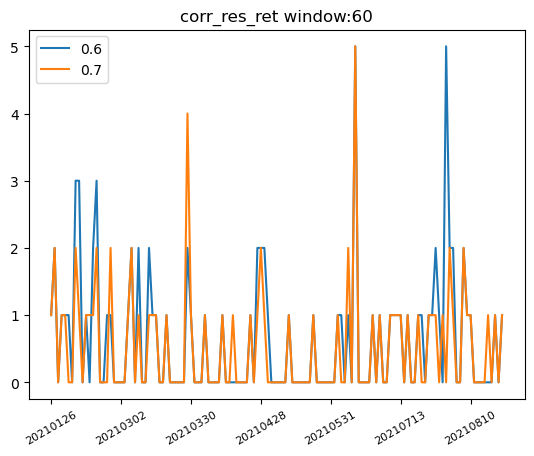

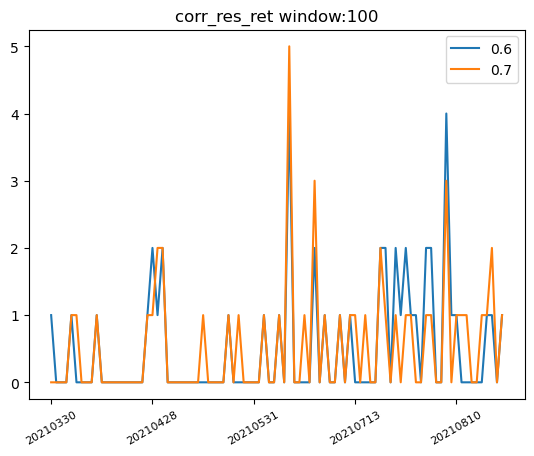

In [63]:
# window_lengths = np.array([20,60,100,120,250])
# vars = np.array([0.5,0.55,0.6,0.65,0.7,0.75])
window_lengths = np.array([60,100])
vars = np.array([0.6,0.7])
for window_length in window_lengths:
    corr_res_ret = pd.DataFrame(columns=vars)
    for var in vars:
        for cur_num in range(window_length, original_returns.shape[0]-6):
            date.append(original_returns.index[cur_num-1])
            # print('date:', date[-1])
            # 获取标准化实验数据
            returns = original_returns.iloc[cur_num-window_length:cur_num]
            returns = (returns - returns.mean())/returns.std()
            eigenvals, eigenvecs = np.linalg.eig(returns.corr())
            idx = eigenvals.argsort()[::-1]   
            pca_eigenvals = eigenvals[idx]/sum(eigenvals)
            for i in range(0, len(pca_eigenvals)+1):
                if sum(pca_eigenvals[:i]) >= var:
                    # pca_eigenvecs = np.sqrt(eigenvals[idx][:i]) * eigenvecs[:, idx][:, :i]
                    pca_eigenvecs = eigenvecs[:, idx][:, :i]
                    break
            factors_P = sm.add_constant(np.dot(returns, pca_eigenvecs))
            OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
            resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
            zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
            # corr_res_ret.at[date[-1],var] = original_returns.iloc[cur_num+6].corr(zscores_P)
            t = original_returns.iloc[cur_num]*zscores_P
            corr_res_ret.at[date[-1],var] = t[t<-0.08].count()
    corr_res_ret.plot()
    plt.title('corr_res_ret window:{}'.format(window_length))
    plt.xticks(rotation=30, fontsize=8)
    plt.show() 

In [64]:
(original_returns.iloc[cur_num+6]*zscores_P).min()

-0.08566718182683168

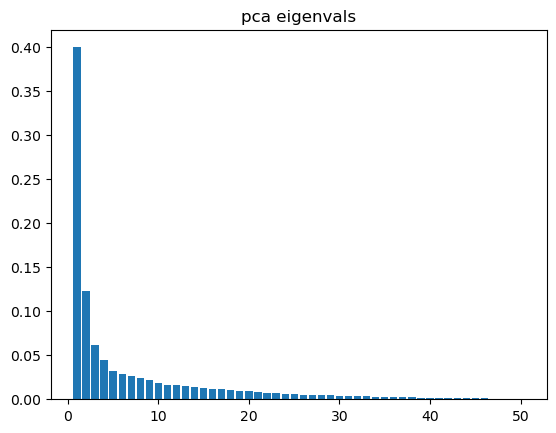

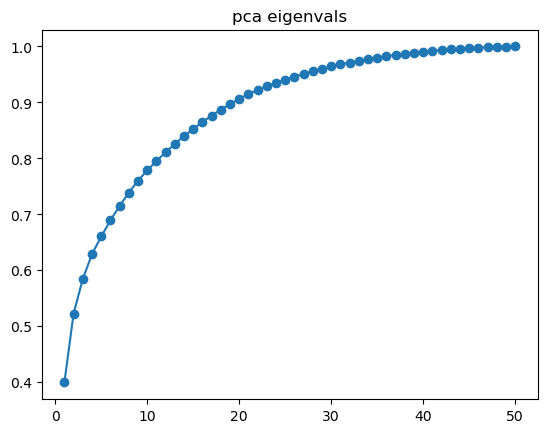

In [5]:
correlations = pd.DataFrame(returns.corr(method='pearson'), index=returns.columns, columns=returns.columns)
eigenvals, eigenvecs = np.linalg.eig(correlations.values)
idx = eigenvals.argsort()[::-1]   
pca_eigenvals = eigenvals[idx]
pca_eigenvecs = eigenvecs[:, idx] # 第一列为第一特征向量
eigen_rate = np.array([i/sum(pca_eigenvals) for i in pca_eigenvals])
cum_rate = eigen_rate.cumsum()
plt.bar(range(1,len(pca_eigenvals)+1), eigen_rate)
plt.title('pca eigenvals')
plt.show()
plt.plot(range(1,len(pca_eigenvals)+1), cum_rate)
plt.scatter(range(1,len(pca_eigenvals)+1), cum_rate)
plt.title('pca eigenvals')
plt.show()

In [6]:
factors_P = sm.add_constant(np.dot(returns, model_P.components_.T)[:,num_components])
OLSmodels_P = {stock: sm.OLS(returns[stock], factors_P).fit() for stock in returns.columns}
resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1].sort_values()  
long_P = zscores_P[zscores_P < -1.5]
short_P = zscores_P[zscores_P > 2]

NameError: name 'model_P' is not defined

In [ ]:
weight = pca_eigenvecs[:,0]/returns.std()

600000.SH    0.161849
600009.SH    0.085014
600016.SH    0.186503
600028.SH    0.122751
600030.SH    0.203606
600031.SH    0.154856
600036.SH    0.181647
600048.SH    0.131718
600050.SH    0.116273
600104.SH    0.091543
600196.SH    0.075512
600276.SH    0.112292
600309.SH    0.125326
600438.SH    0.109103
600519.SH    0.126751
600547.SH    0.095433
600570.SH    0.108764
600585.SH    0.123964
600588.SH    0.083149
600690.SH    0.137744
600703.SH    0.131038
600745.SH    0.064251
600809.SH    0.125875
600837.SH    0.170318
600887.SH    0.152409
600893.SH    0.144551
600918.SH    0.166554
601012.SH    0.120476
601066.SH    0.187373
601088.SH    0.103972
601138.SH    0.085020
601166.SH    0.140278
601211.SH    0.230015
601288.SH    0.124498
601318.SH    0.190887
601336.SH    0.161082
601398.SH    0.143042
601601.SH    0.163366
601628.SH    0.186158
601668.SH    0.136764
601688.SH    0.220474
601818.SH    0.143271
601857.SH    0.129263
601888.SH    0.109905
601899.SH    0.165852
601995.SH 

In [ ]:
cur_ret_P = []
cur_ret_H = []
cur_ret__ = []
cur_ret_ = []
cum_ret_P = [0]
cum_ret_H = [0]
cum_ret__ = [0]
cum_ret_ = [0]

date = []
window_length = 200
nb_cluster = 19
n_component = 50
for cur_num in range(window_length, history_returns.shape[0]):
    date.append(history_returns.index[cur_num-1])
    print('date:', date[-1])
    # 获取标准化实验数据
    date.append(history_returns.index[cur_num-1])
    print('date:', date[-1])
    # 获取标准化实验数据
    original_returns = history_returns.iloc[cur_num-window_length:cur_num]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    sorted_correlations, HPCA_corr = correlations(returns,nb_cluster)
    sorted_returns = original_returns[sorted_correlations.columns] 
    eigenvals_P, eigenvecs_P = np.linalg.eig(sorted_correlations)
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
    fct_P = np.dot(sorted_returns/sorted_returns.std(),pca_eigenvecs)
    OLSmodels_P = {stock: sm.OLS(sorted_returns[stock], fct_P).fit() for stock in sorted_returns.columns}
    resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
    zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
    long_P = zscores_P[zscores_P < -1.5]
    short_P = zscores_P[zscores_P > 1.5]

    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :n_component]  
    fct_H = np.dot(sorted_returns/sorted_returns.std(),hpca_eigenvecs)
    OLSmodels_H = {stock: sm.OLS(sorted_returns[stock], fct_H).fit() for stock in sorted_returns.columns}
    resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()}) #残差一样？？？
    zscores_H = ((resids_H - resids_H.mean()) / resids_H.std()).iloc[-1]
    long_H = zscores_H[zscores_H < -1.5]
    short_H = zscores_H[zscores_H > 1.5]
    ########################################################
    # HPCA选股
    print('HPCA：', end='')
    if len(long_H) != 0:
        weights_long_H = long_H * (1 / long_H.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_H = long_H
    if len(short_H) != 0:
        weights_short_H = short_H * (1 / short_H.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_H = short_H
    cur_ret_H.append((sum(weights_long_H*history_returns[weights_long_H.index].iloc[cur_num]) - sum(weights_short_H*history_returns[weights_short_H.index].iloc[cur_num]))/2 - history_returns.iloc[cur_num].mean())
    cum_ret_H.append((1+cum_ret_H[-1])*(1+cur_ret_H[-1])-1)
    print('cur ret：%.4f'%cur_ret_H[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_H[-1])
    # PCA选股
    print('PCA：', end='')
    if len(long_P) != 0:
        weights_long_P =  long_P * (1 / long_P.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_P = long_P
    if len(short_P) != 0:
        weights_short_P =  short_P * (1 / short_P.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_P = short_P
    cur_ret_P.append((sum(weights_long_P*history_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*history_returns[weights_short_P.index].iloc[cur_num]))/2 - history_returns.iloc[cur_num].mean())
    cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
    cur_ret__.append(history_returns.iloc[cur_num].mean())
    cum_ret__.append((1+cum_ret__[-1])*(1+cur_ret__[-1])-1)
    print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_P[-1])
    # 交叉选股
    print('hpca&pca', end=' ')
    if len(long_P.index.intersection(long_H.index)) == 0 and len(short_P.index.intersection(short_H.index)) == 0:
        cur_ret_.append(- history_returns.iloc[cur_num].mean())
    elif len(long_P.index.intersection(long_H.index)) == 0 and len(short_P.index.intersection(short_H.index)) != 0:
        cur_ret_.append(- history_returns[short_P.index.intersection(short_H.index)].iloc[cur_num].mean() - history_returns.iloc[cur_num].mean())
    elif len(long_P.index.intersection(long_H.index)) != 0 and len(short_P.index.intersection(short_H.index)) == 0:
        cur_ret_.append(history_returns[long_P.index.intersection(long_H.index)].iloc[cur_num].mean() - history_returns.iloc[cur_num].mean())
    else:
        cur_ret_.append((history_returns[long_P.index.intersection(long_H.index)].iloc[cur_num].mean() - history_returns[short_P.index.intersection(short_H.index)].iloc[cur_num].mean())/2 - history_returns.iloc[cur_num].mean())
    cum_ret_.append((1+cum_ret_[-1])*(1+cur_ret_[-1])-1)
    print('cur ret：%.4f'%cur_ret_[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_[-1])
    ########################################################


df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_H[:],cur_ret_[:],cur_ret__[:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cur.plot()
plt.title('cur ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()
df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_H[1:],cum_ret_[1:],cum_ret__[1:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cum.plot()
plt.title('cum ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()